## Colocando os Conhecimentos em Prática

Na aula de hoje, nós revisitaremos a tarefa de classificação de litologia no dataset FORCE utilizando as técnicas aprendidas ao longo da semana.

A partir do que aprendemos na última semana, sabemos que temos três grandes problemas que precisamos abordar a fim de melhorar os resultados de nossa classificação:

- A rede deve ter uma capacidade maior em comparação com a usada na semana 01;
- Devemos tratar do grande desbalanceamento das classes em nossos dados, que fez com que nossa rede inicial prevesse majoritariamente algumas poucas classes.
- Devemos implementar pensar em maneiras de diminuir um possível overfitting, principalmente ao aumentarmos a capacidade de nosso modelo.

Agora é com você! Construa um Multi Layer Perceptron, usando pytorch, para mapear cada ponto do poço para a litologia correta.

> Dica: Considere fazer suas predições em uma janela deslizante.

Abaixo está um passo a passo do que deve ser feito.

1. Leia os dados baixados e extraídos
> Dica: use a biblioteca pandas. Exemplo: pd.read_csv("train.csv", sep=';')
2. Divida os poços em janelas da profundidade que quiser.
3. Construa sua base de treino e teste, bem como o dataloder para elas.
4. Construa seu MLP usando pytorch.
5. Treine o modelo.
6. Extraia as previsões em seu dado de teste para cada janela, em junte-as para formar a segmentação completa do poço.
7. Meça a qualidade de seu algoritmo com métricas a sua escolha.
8. Teste diferentes otimizadores, técnicas de regularização.



In [ ]:
!wget -nc https://raw.githubusercontent.com/bolgebrygg/Force-2020-Machine-Learning-competition/refs/heads/master/lithology_competition/data/hidden_test.csv
!wget -nc https://raw.githubusercontent.com/bolgebrygg/Force-2020-Machine-Learning-competition/refs/heads/master/lithology_competition/data/leaderboard_test_features.csv
!wget -nc https://raw.githubusercontent.com/bolgebrygg/Force-2020-Machine-Learning-competition/refs/heads/master/lithology_competition/data/leaderboard_test_target.csv
!wget -nc https://raw.githubusercontent.com/bolgebrygg/Force-2020-Machine-Learning-competition/refs/heads/master/lithology_competition/data/train.zip

In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder, StandardScaler
from torchmetrics.functional import accuracy
from collections import Counter
from tqdm import tqdm

In [2]:
# Lendo os dados

data_dir = '.'

df_train = pd.read_csv(f"{data_dir}/train.csv", sep=';')
df_test = pd.read_csv(f"{data_dir}/leaderboard_test_features.csv", sep=';')
df_test_target = pd.read_csv(f"{data_dir}/leaderboard_test_target.csv", sep=';')
df_test = pd.merge(df_test, df_test_target, on=["WELL", "DEPTH_MD"], how="inner")

In [3]:
df_train.head()

,WELL,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,GROUP,FORMATION,CALI,RSHA,RMED,...,ROP,DTS,DCAL,DRHO,MUDWEIGHT,RMIC,ROPA,RXO,FORCE_2020_LITHOFACIES_LITHOLOGY,FORCE_2020_LITHOFACIES_CONFIDENCE
0,15/9-13,494.528,437641.96875,6470972.5,-469.501831,NORDLAND GP.,NaN,19.480835,NaN,1.611410,...,34.636410,NaN,NaN,-0.574928,NaN,NaN,NaN,NaN,65000,1.0
1,15/9-13,494.680,437641.96875,6470972.5,-469.653809,NORDLAND GP.,NaN,19.468800,NaN,1.618070,...,34.636410,NaN,NaN,-0.570188,NaN,NaN,NaN,NaN,65000,1.0
2,15/9-13,494.832,437641.96875,6470972.5,-469.805786,NORDLAND GP.,NaN,19.468800,NaN,1.626459,...,34.779556,NaN,NaN,-0.574245,NaN,NaN,NaN,NaN,65000,1.0
3,15/9-13,494.984,437641.96875,6470972.5,-469.957794,NORDLAND GP.,NaN,19.459282,NaN,1.621594,...,39.965164,NaN,NaN,-0.586315,NaN,NaN,NaN,NaN,65000,1.0
4,15/9-13,495.136,437641.96875,6470972.5,-470.109772,NORDLAND GP.,NaN,19.453100,NaN,1.602679,...,57.483765,NaN,NaN,-0.597914,NaN,NaN,NaN,NaN,65000,1.0


In [4]:
# Nomes das litologias
lithology_keys = {
    30000: 'Sandstone',
    65030: 'Sandstone/Shale',
    65000: 'Shale',
    80000: 'Marl',
    74000: 'Dolomite',
    70000: 'Limestone',
    70032: 'Chalk',
    88000: 'Halite',
    86000: 'Anhydrite',
    99000: 'Tuff',
    90000: 'Coal',
    93000: 'Basement'
}

target_col = "FORCE_2020_LITHOFACIES_LITHOLOGY"
feature_cols = ["GR", "RHOB", "NPHI", "PEF", "DTC", "RDEP", "RSHA", "RMED"]

# Removendo valores faltantes
df_train = df_train.dropna(subset=feature_cols+[target_col]).reset_index(drop=True)
df_test = df_test.dropna(subset=feature_cols+[target_col]).reset_index(drop=True)

# Codificando as labels para que as possamos passar para o modelo
le = LabelEncoder()
all_possible_classes = list(lithology_keys.keys())
le.fit(all_possible_classes)
df_train[target_col] = le.transform(df_train[target_col])
df_test[target_col] = le.transform(df_test[target_col])

# Normalizando as featues
scaler = StandardScaler()
df_train[feature_cols] = scaler.fit_transform(df_train[feature_cols])
df_test[feature_cols] = scaler.transform(df_test[feature_cols])

In [5]:
# Aqui estamos listando todos os poços presentes no dataset de treino
wells = df_train["WELL"].unique()
print(wells)

['15/9-13' '15/9-15' '15/9-17' '16/10-3' '16/10-5' '16/4-1' '16/7-5'
 '25/11-19 S' '25/2-13 T4' '25/2-14' '25/2-7' '25/3-1' '25/4-5' '25/5-1'
 '25/5-4' '25/8-5 S' '25/8-7' '25/9-1' '26/4-1' '29/6-1' '30/6-5'
 '31/2-19 S' '31/2-7' '31/2-8' '31/2-9' '31/3-2' '31/3-4' '31/4-5'
 '32/2-1' '33/9-17' '34/10-21' '34/10-35' '34/11-2 S' '34/12-1' '34/2-4'
 '34/7-21' '34/8-1' '35/11-1' '35/11-6' '35/11-7' '35/12-1' '35/8-4'
 '7/1-2 S']


In [6]:
df_train["WELL"].value_counts()

WELL
33/9-17       17337
31/2-19 S     16308
34/10-21      13945
15/9-15       13290
15/9-17       12873
26/4-1        12824
25/2-7        12043
16/7-5        10266
34/12-1        9109
35/11-6        8378
34/7-21        7576
25/8-5 S       7455
35/11-7        7227
35/12-1        7073
25/11-19 S     6908
31/2-8         6582
35/11-1        6195
25/3-1         6010
31/3-4         5223
34/11-2 S      5073
16/10-3        4578
25/2-14        3845
34/8-1         3735
25/9-1         3596
34/2-4         3588
29/6-1         3409
25/5-1         2954
32/2-1         2789
30/6-5         2572
16/10-5        2498
25/8-7         2452
35/8-4         2263
31/4-5         2046
25/4-5         1891
31/2-9         1787
15/9-13        1623
25/2-13 T4     1574
7/1-2 S        1530
25/5-4         1328
34/10-35       1066
31/2-7         1008
31/3-2          620
16/4-1          615
Name: count, dtype: int64

In [38]:
# Criando janelas nos dados
# Optimized function for creating windows
def create_windows(data, features, target, window_size=10):
    X = np.lib.stride_tricks.sliding_window_view(data[features].values, (window_size, len(features)))[:-1, :, :]
    Y = data[target].iloc[window_size:].values
    return X.squeeze(), Y

window_size = 10
X_train = []
y_train = []
for well in wells:
    well_data = df_train[df_train['WELL'] == well]
       
    x_well, y_well = create_windows(well_data, feature_cols, target_col, window_size=window_size)
    X_train.append(x_well)
    y_train.append(y_well)

X_train = np.concatenate(X_train, axis=0)
y_train = np.concatenate(y_train, axis=0)
X_test, y_test = create_windows(df_test, feature_cols, target_col, window_size=window_size)

print(f"X_train shape: {X_train.shape} || X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape} || y_test shape: {y_test.shape}")

X_train shape: (244632, 10, 8) || X_test shape: (26583, 10, 8)
y_train shape: (244632,) || y_test shape: (26583,)


In [39]:
# Criando o dataset que utilizaremos
class WellDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

# definindo os datasets
train_dataset = WellDataset(X_train, y_train)
test_dataset = WellDataset(X_test, y_test)

# definindo os dataloaders
batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last = True)
test_loader = DataLoader(test_dataset, batch_size=8)

In [40]:
import torch.nn as nn

class LayersBlock(nn.Module):
    def __init__(self, in_features, out_features, hidden_size=None, hidden_num=0, activation='ELU', dropout=0):
        super(LayersBlock, self).__init__()

        # Definindo as possíveis funções de ativação
        activations = {
            'ELU': nn.ELU(),
            'ReLU': nn.ReLU(),
            'Tanh': nn.Tanh(),
            'Sigmoid': nn.Sigmoid(),
            'LeakyReLU': nn.LeakyReLU(),
            'GELU': nn.GELU(),
            'none': nn.Identity()
        }
        if activation not in activations:
            raise ValueError(f"Unsupported activation: {activation}")
        self.activation = activations[activation]

        # ModuleList para armazenar nossas camadas
        self.layers = nn.ModuleList()

        
        if hidden_num > 0 and hidden_size is not None:
            # Primeira hidden layer
            self.layers.append(self._make_layer(in_features, hidden_size, dropout))

            # Adicionando as demais hidden_layers
            for _ in range(hidden_num - 1):
                self.layers.append(self._make_layer(hidden_size, hidden_size, dropout))

            # Camada final
            self.layers.append(self._make_layer(hidden_size, out_features, 0))
        else:
            
            self.layers.append(self._make_layer(in_features, out_features, dropout))

    def _make_layer(self, in_features, out_features, dropout):
        """Função auxiliar para nos ajudar a definir uma camada de nosso bloco"""
        layer = nn.Sequential(
            nn.Linear(in_features, out_features),
            nn.BatchNorm1d(out_features),
            self.activation,
            nn.Dropout(p=dropout) if dropout > 0 else nn.Identity()
        )
        return layer

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = layer(x)
        x = self.layers[-1](x)
        return x



class MLP(nn.Module):
    def __init__(self, in_features, out_features):
        super(MLP, self).__init__()

        h = 'ELU'

        self.l1 = LayersBlock(in_features, in_features // 2, hidden_num = 0, activation = h, dropout = 0.5)
        self.l2 = LayersBlock(in_features // 2, in_features // 4, hidden_size = in_features // 2,
                              hidden_num = 2, activation = h, dropout = 0.5)
        self.l3 = LayersBlock(in_features // 4, out_features, hidden_num = 0, activation = 'none', dropout = 0)

        self.final_activation = nn.Identity()
        
    def forward(self, x):
        x = self.l1(x)
        x = self.l2(x)
        x = self.l3(x)
        return self.final_activation(x)

In [41]:
# Treino de uma única epoch
def train_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    for X_batch, Y_batch in loader:
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)

        # Precisamos achatar nossa matriz de entrada para poder passar pelas camadas lineares
        X_batch = X_batch.reshape(X_batch.shape[0], -1)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, Y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * X_batch.size(0)
        preds = torch.argmax(outputs, dim=1)
        total_correct += (preds == Y_batch).sum().item()
        total_samples += X_batch.size(0)

    avg_loss = total_loss / total_samples
    avg_acc = total_correct / total_samples
    return avg_loss, avg_acc

In [42]:
# Avaliação do modelo
def eval_model(model, loader, criterion):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for X_batch, Y_batch in loader:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            X_batch = X_batch.reshape(X_batch.shape[0], -1)

            outputs = model(X_batch)
            loss = criterion(outputs, Y_batch)

            total_loss += loss.item() * X_batch.size(0)
            preds = torch.argmax(outputs, dim=1)
            total_correct += (preds == Y_batch).sum().item()
            total_samples += X_batch.size(0)

    avg_loss = total_loss / total_samples
    avg_acc = total_correct / total_samples
    return avg_loss, avg_acc

In [43]:
# Inicializando o modelo
num_features = len(feature_cols)
num_classes = len(le.classes_)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLP(in_features=window_size*num_features, out_features=num_classes).to(device)

# Vamos usar o toch.ones para evitar possíveis divisões por 0
class_counts = torch.ones(num_classes)
unique_values, c = np.unique(y_train, return_counts=True)

class_counts[unique_values] += torch.tensor(c)

class_weights = 100.0 / class_counts
class_weights = class_weights / class_weights.sum()
class_weights = class_weights.to(device)



#criterion = nn.CrossEntropyLoss(weight=class_weights)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

In [44]:
class_weights

tensor([8.0942e-06, 2.2189e-06, 1.1656e-05, 2.4591e-05, 2.6424e-04, 2.0147e-03,
        4.9883e-05, 3.3242e-01, 3.3242e-01, 1.8265e-04, 3.3242e-01, 1.8345e-04],
       device='cuda:0')

In [45]:
# Treinando o modelo
epochs = 100

with tqdm(range(1, epochs + 1), desc="Training Progress", unit="epoch") as pbar:
    for epoch in pbar:
        # Train for one epoch
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion)

        # Perform validation every 5 epochs
        if epoch % 5 == 0:
            val_loss, val_acc = eval_model(model, test_loader, criterion)

        # Update tqdm with train/validation losses dynamically
        pbar.set_postfix({
            "Train Loss": f"{train_loss:.4f}",
            "Train Acc": f"{train_acc:.4f}",
            "Val Loss": f"{val_loss:.4f}" if val_loss is not None else "N/A",
            "Val Acc": f"{val_acc:.4f}" if val_acc is not None else "N/A"
        })

# Evaluate on test set
test_loss, test_acc = eval_model(model, test_loader, criterion)
print(f"Test - Loss: {test_loss:.4f}, Acc: {test_acc:.4f}")

Training Progress: 100%|██████████| 100/100 [07:06<00:00,  4.27s/epoch, Train Loss=0.7317, Train Acc=0.7549, Val Loss=0.5599, Val Acc=0.8449]


Test - Loss: 0.5599, Acc: 0.8449


100%|██████████| 30579/30579 [00:24<00:00, 1263.52it/s]


(244632,)


100%|██████████| 6646/6646 [00:05<00:00, 1301.90it/s]


(26583,)


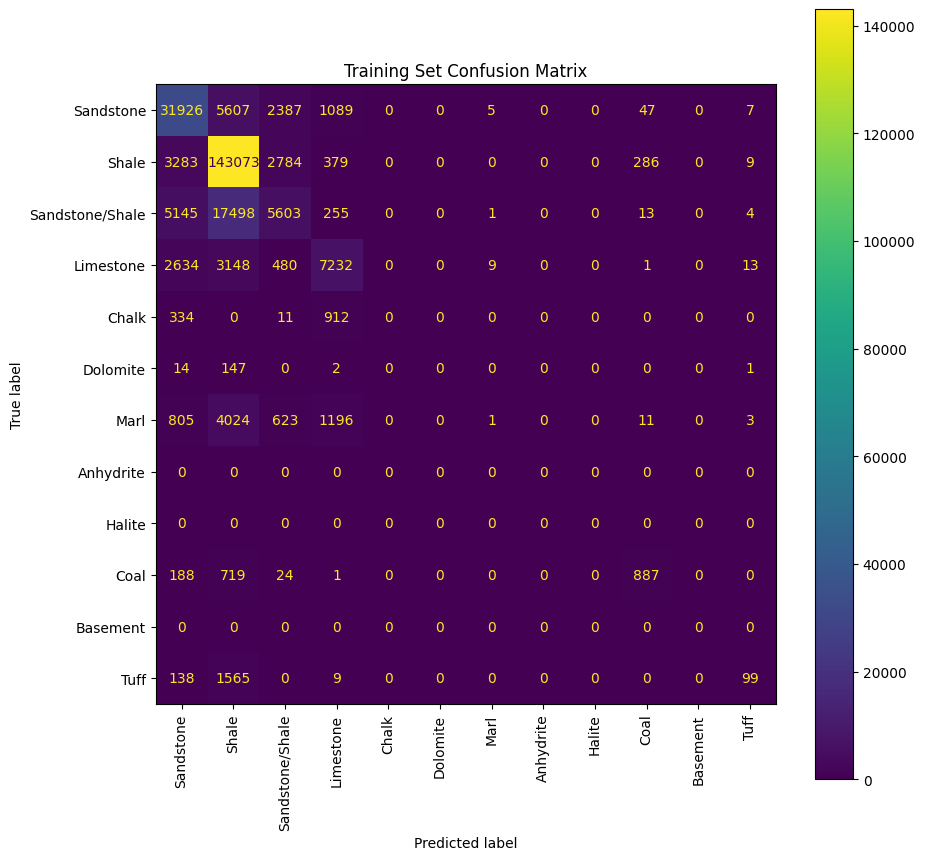

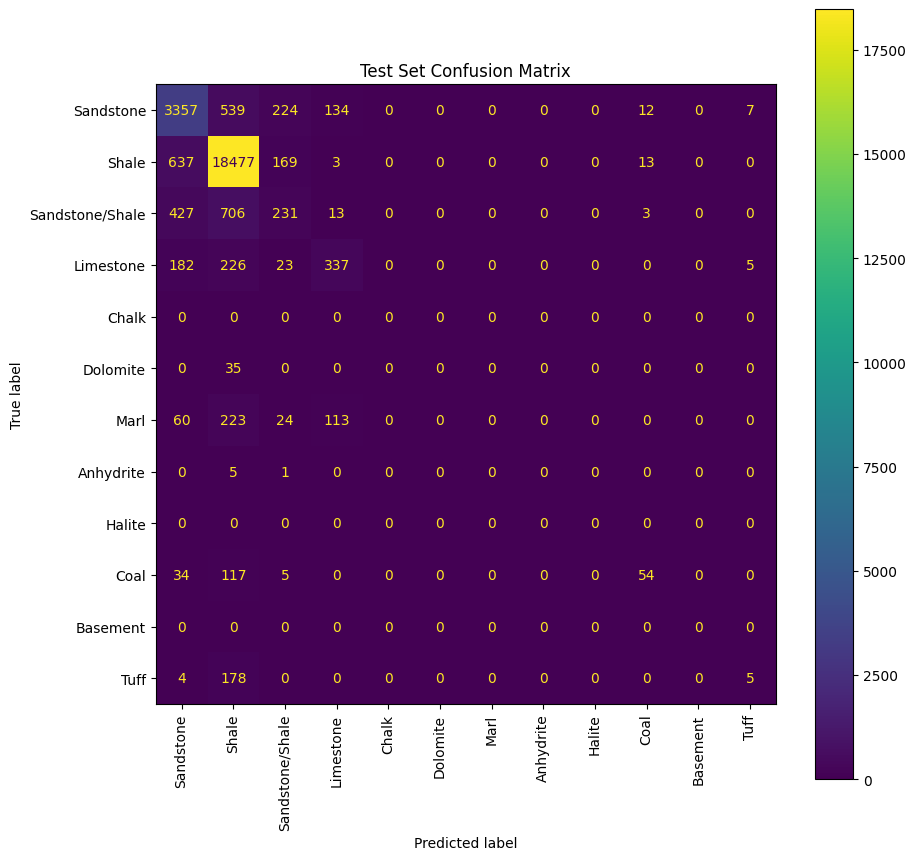

In [47]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Extrai todas as predições para cada janela
def get_predictions(model, loader):
    model.eval()
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for X_batch, Y_batch in tqdm(loader):
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            X_batch = X_batch.reshape(X_batch.shape[0], -1)
            outputs = model(X_batch)
            preds = torch.argmax(outputs, dim=1)
            all_preds.append(preds.cpu().numpy())
            all_targets.append(Y_batch.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)
    print(all_preds.shape)
    return all_targets, all_preds

eval_train_loader = DataLoader(train_dataset, batch_size=8, shuffle=False, drop_last = False)
eval_test_loader = DataLoader(test_dataset, batch_size=4, drop_last = False)

train_targets, train_preds = get_predictions(model, eval_train_loader)
test_targets, test_preds = get_predictions(model, eval_test_loader)

# Recupera o nome das labels
label_names = [lithology_keys[k] for k in le.inverse_transform(range(num_classes))]

# Calculando a matriz de confusão para cada janela
train_cm = confusion_matrix(train_targets, train_preds, labels=range(num_classes))
test_cm = confusion_matrix(test_targets, test_preds, labels=range(num_classes))

# Exibindo a matriz de confusão do treino
fig, ax = plt.subplots(figsize=(10,10))
disp = ConfusionMatrixDisplay(confusion_matrix=train_cm, display_labels=label_names)
disp.plot(ax=ax, xticks_rotation='vertical')
plt.title("Training Set Confusion Matrix")
plt.show()

# Exibindo a matriz de confusão do teste
fig, ax = plt.subplots(figsize=(10,10))
disp = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=label_names)
disp.plot(ax=ax, xticks_rotation='vertical')
plt.title("Test Set Confusion Matrix")
plt.show()


In [49]:
# Função auxiliar para exibir os resultados
def makeplot(well:pd.DataFrame, top_depth , bottom_depth) -> None:
    """
    Function that creates and saves plot
        Arguments:
        ---------
            - well (pd.DataFrame): Well log data from a single well
            - top_depth (float): Maximum depth of the well
            - bottom_depth (float): Minimum depth of the well
            - model_name (str): Name of the model used
            - selected_well (str): Name of the selected well
            - output_dir (str): Path to save plot.
        Return:
        ---------
            None
    """

    lithology_numbers = {0: {'lith':'Sandstone', 'lith_num':1, 'hatch': '..', 'color':'#000000'},
                 1: {'lith':'Sandstone/Shale', 'lith_num':2, 'hatch':'-.', 'color':'#ffe119'},
                 2: {'lith':'Shale', 'lith_num':3, 'hatch':'--', 'color':'#bebebe'},
                 3: {'lith':'Marl', 'lith_num':4, 'hatch':'', 'color':'#7cfc00'},
                 4: {'lith':'Dolomite', 'lith_num':5, 'hatch':'-/', 'color':'#8080ff'},
                 5: {'lith':'Limestone', 'lith_num':6, 'hatch':'+', 'color':'#80ffff'},
                 6: {'lith':'Chalk', 'lith_num':7, 'hatch':'..', 'color':'#80ffff'},
                 7: {'lith':'Halite', 'lith_num':8, 'hatch':'x', 'color':'#7ddfbe'},
                 8: {'lith':'Anhydrite', 'lith_num':9, 'hatch':'', 'color':'#ff80ff'},
                 9: {'lith':'Tuff', 'lith_num':10, 'hatch':'||', 'color':'#ff8c00'},
                 10: {'lith':'Coal', 'lith_num':11, 'hatch':'', 'color':'black'},
                 11: {'lith':'Basement', 'lith_num':12, 'hatch':'-|', 'color':'#ef138a'}}

    fig, ax = plt.subplots(figsize=(15,10))


    ax1 = plt.subplot2grid((1,6), (0,0), rowspan=1, colspan = 1)
    ax2 = plt.subplot2grid((1,6), (0,1), rowspan=1, colspan = 1, sharey = ax1)
    ax3 = plt.subplot2grid((1,6), (0,2), rowspan=1, colspan = 1, sharey = ax1) #Twins the y-axis for the density track with the neutron track
    ax4 = plt.subplot2grid((1,6), (0,3), rowspan=1, colspan = 1, sharey = ax1)
    ax5 = plt.subplot2grid((1,6), (0,4), rowspan=1, colspan = 1, sharey = ax1)
    ax6 = plt.subplot2grid((1,6), (0,5), rowspan=1, colspan = 1, sharey = ax1)


    ax10 = ax1.twiny()
    ax10.xaxis.set_visible(False)
    ax11 = ax2.twiny()
    ax11.xaxis.set_visible(False)
    ax12 = ax3.twiny()
    ax12.xaxis.set_visible(False)
    ax13 = ax4.twiny()
    ax13.xaxis.set_visible(False)
    ax14 = ax5.twiny()
    ax14.xaxis.set_visible(False)
    ax15 = ax6.twiny()
    ax15.xaxis.set_visible(False)


    ax1.plot(well["GR"], well['DEPTH_MD'], color = "green", linewidth = 0.5)
    ax1.set_xlabel("Gamma")
    ax1.xaxis.label.set_color("green")
    ax1.set_ylabel("Depth (m)")
    ax1.tick_params(axis='x', colors="green")
    ax1.spines["top"].set_edgecolor("green")
    ax1.title.set_color('green')


    ax2.plot(well["RHOB"], well['DEPTH_MD'], color = "red", linewidth = 0.5)
    ax2.set_xlabel("Density")
    ax2.xaxis.label.set_color("red")
    ax2.tick_params(axis='x', colors="red")
    ax2.spines["top"].set_edgecolor("red")



    ax3.plot(well["NPHI"], well['DEPTH_MD'], color = "blue", linewidth = 0.5)
    ax3.set_xlabel('Neutron')
    ax3.xaxis.label.set_color("blue")
    ax3.tick_params(axis='x', colors="blue")
    ax3.spines["top"].set_edgecolor("blue")



    ax4.plot(well["DTC"], well['DEPTH_MD'], color = "purple", linewidth = 0.5)
    ax4.set_xlabel('Compressional Wave')
    ax4.xaxis.label.set_color("purple")
    ax4.tick_params(axis='x', colors="purple")
    ax4.spines["top"].set_edgecolor("purple")

    ax5.plot(well["FORCE_2020_LITHOFACIES_LITHOLOGY"], well['DEPTH_MD'], color = "black", linewidth = 0.5)
    ax5.set_xlabel("Lithology")
    ax5.set_xlim(0, 1)
    ax5.xaxis.label.set_color("black")
    ax5.tick_params(axis='x', colors="black")
    ax5.spines["top"].set_edgecolor("black")

    ax6.plot(well["LITHOLOGY_PREDICTED"], well['DEPTH_MD'], color = "black", linewidth = 0.5)
    ax6.set_xlabel(f"Lithology Predictions")
    ax6.set_xlim(0, 1)
    ax6.xaxis.label.set_color("black")
    ax6.tick_params(axis='x', colors="black")
    ax6.spines["top"].set_edgecolor("black")

    for key in lithology_numbers.keys():
        color = lithology_numbers[key]['color']
        hatch = lithology_numbers[key]['hatch']
        ax5.fill_betweenx(well['DEPTH_MD'], 0, well['FORCE_2020_LITHOFACIES_LITHOLOGY'], where=(well['FORCE_2020_LITHOFACIES_LITHOLOGY']==key),
                         facecolor=color, hatch=hatch)
        ax6.fill_betweenx(well['DEPTH_MD'], 0, well['LITHOLOGY_PREDICTED'], where=(well['LITHOLOGY_PREDICTED']==key),
                         facecolor=color, hatch=hatch)


    ax5.set_xticks([0, 1])
    ax6.set_xticks([0, 1])

    for ax in [ax1, ax2, ax3, ax4, ax5, ax6]:
        ax.set_ylim(bottom_depth, top_depth)
        ax.grid(which='major', color='lightgrey', linestyle='-')
        ax.xaxis.set_ticks_position("top")
        ax.xaxis.set_label_position("top")
        ax.spines["top"].set_position(("axes", 1.02))


    for ax in [ax2, ax3, ax4, ax5, ax6]:
        plt.setp(ax.get_yticklabels(), visible = False)

    plt.tight_layout()
    fig.subplots_adjust(wspace = 0.15)

    plt.plot()

In [50]:
# Adicionando as predicões em nosso dataframe pandas para que possamos chamar makeplots
def add_array_as_column(df, array, column_name):
    """
    Concatenates an array as a new column in a pandas DataFrame.

    Parameters:
        df (pd.DataFrame): The DataFrame to modify.
        array (list or np.ndarray): The array to add as a column.
        column_name (str): The name of the new column.

    Returns:
        pd.DataFrame: A new DataFrame with the added column.
    """
    if len(df) != len(array):
        raise ValueError("Length of the array must match the number of rows in the DataFrame.")

    df[column_name] = array
    return df

In [51]:
# Transformando as predições das janelas em predições individuais.
# Aqui, como minhas janelas tinham overlap entre si, usei um sistema de votação para dicidir a previsão final do modelo.
def create_slice_predictions(window_predictions, window_size):
    """
    Create slice predictions from window predictions for a classification problem.

    Parameters:
        window_predictions (np.ndarray): Array of predicted labels for each window.
        window_size (int): The size of the sliding window.

    Returns:
        np.ndarray: Array of predicted labels for each slice in the time series.
    """
    # Number of slices in the original time series
    num_slices = len(window_predictions) + window_size

    # Initialize the slice predictions array
    slice_predictions = np.zeros(num_slices, dtype=int)

    # Voting system for each slice
    for i in range(num_slices-1):
        votes = Counter()
        for j in range(max(0, i - window_size + 1), min(len(window_predictions), i + 1)):
            # Calculate distance to the edges of the window
            dist_from_start = i - j
            dist_from_end = window_size - 1 - dist_from_start
            weight = min(dist_from_start, dist_from_end) + 1

            # Add weighted vote for the current window prediction
            votes[window_predictions[j]] += weight


        # Assign the label with the highest weighted votes
        slice_predictions[i] = max(votes, key=votes.get)
    slice_predictions[-1] = slice_predictions[-2]

    return slice_predictions

In [52]:
slice_preds = create_slice_predictions(test_preds, 10)

In [53]:
plot_df = add_array_as_column(df_test, slice_preds, 'LITHOLOGY_PREDICTED')


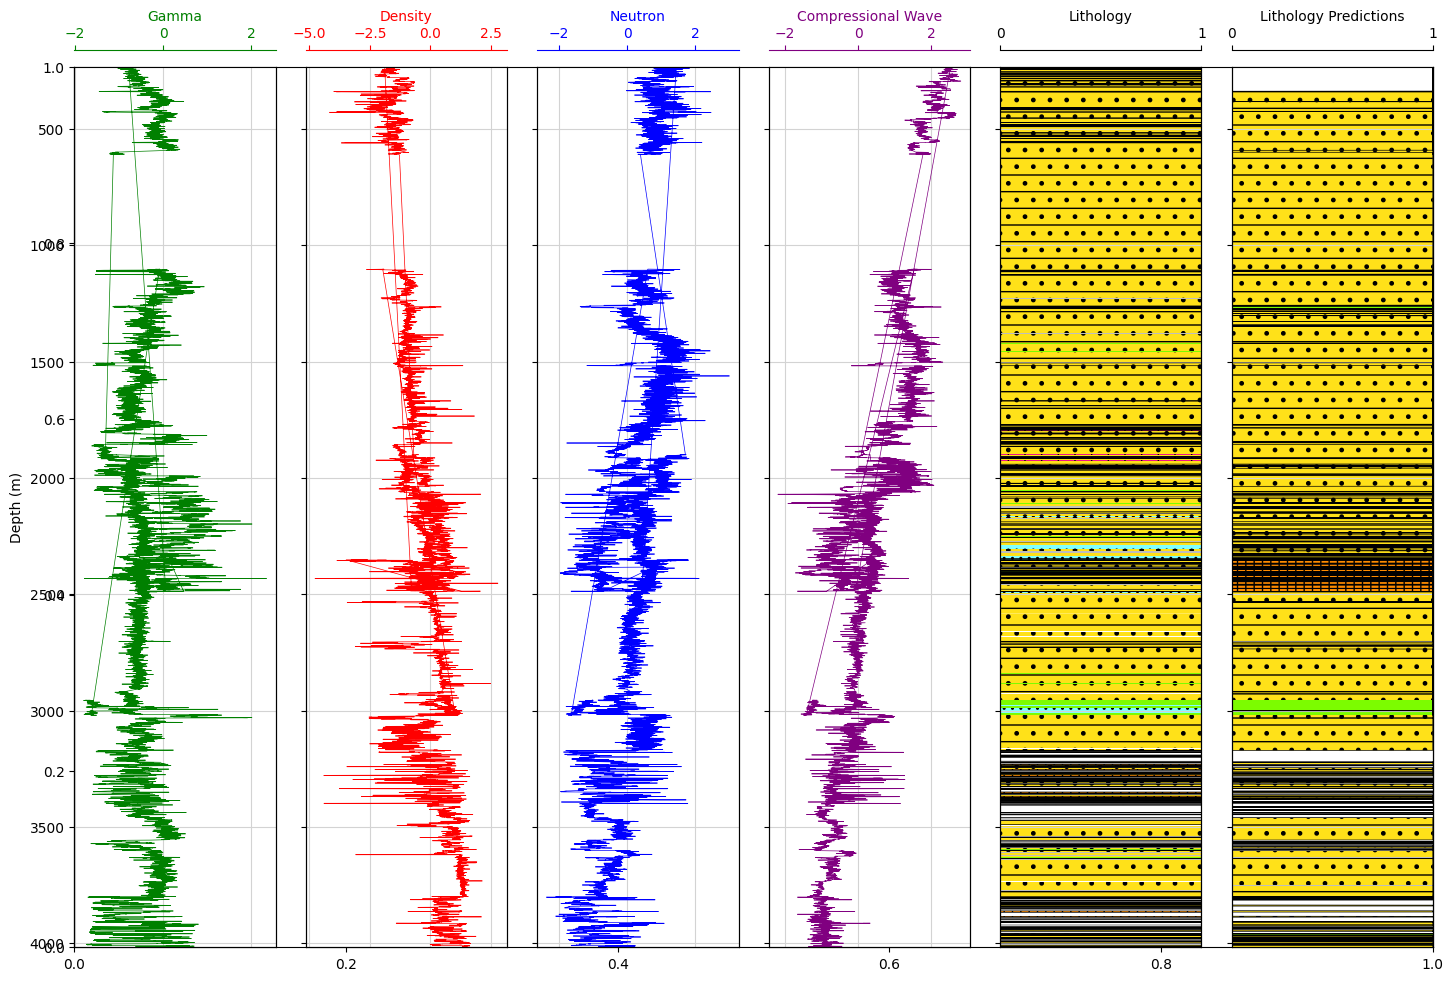

In [54]:
makeplot(plot_df, plot_df['DEPTH_MD'].min(), plot_df['DEPTH_MD'].max())